# A journey Through PRML

In [49]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from time import sleep
from requests_html import HTMLSession

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams.update({'font.size': 13})

In [4]:
api_token = os.environ["TOGGL_API_TOKEN"]
password = os.environ["TOGGL_PASSWORD"]
mail = "g.duran@me.com"

In [5]:
chapter_names = ["Chapter 1: Introduction",
 "Chapter 2: Probability distributions",
 "Chapter 3: Linear Models for Regression",
 "Chapter 4: Linear Models for Classification",
 "Chapter 5: Neural Networks",
 "Chapter 6: Kernel Methods",
 "Chapter 7: Sparse Kernel Machines",
 "Chapter 8: Graphical Models",
 "Chapter 9: Mixture Models and EM",
 "Chapter 10: Approximate Inference",
 "Chapter 11: Sampling Methods",
 "Chapter 12: Continuous Latent Variables",
 "Chapter 13: Sequential Data",
 "Chapter 14: Combining Models"]

In [6]:
headers = {
    "Content-Type": "application/json"
}

In [7]:
url_me = "https://api.track.toggl.com/api/v8/me"
r = requests.get(url_me, headers=headers, auth=(mail, password))
data = r.json()["data"]
print(data["fullname"], data["created_at"])

Gerardo Durán 2015-04-28T02:55:50+00:00


## Get workspaces

In [8]:
url_workspace = "https://api.track.toggl.com/api/v8/workspaces"
r = requests.get(url_workspace, headers=headers, auth=(mail, password))
workspace_id = r.json()[0]["id"]
workspace_id

921814

## Get workspace projects

In [9]:
url_projects = f"https://api.track.toggl.com/api/v8/workspaces/{workspace_id}/projects"
r = requests.get(url_projects, headers=headers, auth=(mail, password))

ml_project, *_ = [project for project in r.json() if project["name"] == "Machine Learning"]
ml_project

{'id': 15174272,
 'guid': 'c38bdfe7-084c-41fa-bcac-91fbb6e8a672',
 'wid': 921814,
 'name': 'Machine Learning',
 'billable': False,
 'is_private': True,
 'active': True,
 'template': False,
 'at': '2020-06-09T02:16:07+00:00',
 'created_at': '2016-04-14T04:35:49+00:00',
 'color': '6',
 'auto_estimates': False,
 'actual_hours': 2695,
 'hex_color': '#06a893'}

## My Time Entries

In [10]:
time_ranges = ["2018-01-01", "2019-01-01", "2020-01-01", "2020-09-19"]
time_ranges = [(init, end) for init, end in zip(time_ranges[:-1], time_ranges[1:])]

In [11]:
def extract_report(start_date, end_date, project_id, api_token, page=1):
    url_details = "https://api.track.toggl.com/reports/api/v2/details"
    params = {
        "user_agent": mail,
        "workspace_id": workspace_id,
        "since": start_date,
        "until": end_date,
        "page": page,
        "project_ids": project_id
    }
    r = requests.get(url_details, params=params, auth=(api_token, "api_token"))
    r.raise_for_status()
    
    return r

In [12]:
total_entries = []
for start_date, end_date in tqdm(time_ranges):
    info = extract_report(start_date, end_date, ml_project["id"], api_token).json()
    entries, per_page_entries = info["total_count"], info["per_page"]
    n_pages = entries // per_page_entries + 1
    total_entries.extend(info["data"])
    sleep(1)
    for page in tqdm(range(2, n_pages + 1), leave=False):
        info = extract_report(start_date, end_date, ml_project["id"], api_token, page=page).json()
        total_entries.extend(info["data"])
        sleep(1)

In [13]:
len(total_entries)

2374

# PRML

In [14]:
prml = pd.DataFrame(total_entries).set_index("start")
prml = prml[prml.description.str.contains("^[Bb]ishop")].sort_index()
prml.index = pd.to_datetime(prml.index, utc=True).tz_convert('America/Mexico_City')
prml = prml.sort_index()
prml.head()

,id,pid,tid,uid,description,end,updated,dur,user,use_stop,client,project,project_color,project_hex_color,task,billable,is_billable,cur,tags
start,,,,,,,,,,,,,,,,,,,
2018-07-10 17:20:59-05:00,920407819,15174272,None,1670359,Bishop Ch3,2018-07-10T17:36:24-05:00,2018-07-10T17:36:24-05:00,925000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]
2018-07-11 12:48:17-05:00,921304355,15174272,None,1670359,Bishop Ch3,2018-07-11T12:56:28-05:00,2018-07-11T12:56:28-05:00,491000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]
2018-07-13 13:09:52-05:00,923358919,15174272,None,1670359,Bishop Ch3,2018-07-13T14:52:18-05:00,2018-07-13T14:52:19-05:00,6146000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]
2018-07-13 20:20:59-05:00,923538451,15174272,None,1670359,Bishop Ch3,2018-07-13T21:30:07-05:00,2018-07-13T21:30:22-05:00,4148000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]
2018-07-14 06:36:54-05:00,923603030,15174272,None,1670359,Bishop Ch1,2018-07-14T06:40:13-05:00,2018-07-14T06:40:15-05:00,199000,Gerardo Durán,True,None,Machine Learning,0,#06a893,None,None,False,None,[]


In [15]:
prml["clocked_hours"] = prml["dur"] * 0.001 / 60 ** 2

## Temporal Analysis

In [16]:
# Date of the first time entry
prml.index.min().strftime("%Y-%m-%d")

'2018-07-10'

In [17]:
# Total time of tracked study
days_study = prml.index.max() - prml.index.min()
days_study

Timedelta('792 days 02:38:44')

In [18]:
# Periods before Ch.1: just goofing around
prml.loc[:"2018-08-27", "description"]

start
2018-07-10 17:20:59-05:00     Bishop Ch3
2018-07-11 12:48:17-05:00     Bishop Ch3
2018-07-13 13:09:52-05:00     Bishop Ch3
2018-07-13 20:20:59-05:00     Bishop Ch3
2018-07-14 06:36:54-05:00     Bishop Ch1
2018-07-14 06:44:45-05:00     Bishop Ch1
2018-07-14 07:27:37-05:00     Bishop Ch1
2018-07-17 10:54:01-05:00     Bishop Ch1
2018-07-17 12:23:25-05:00     Bishop Ch1
2018-07-18 12:06:39-05:00     Bishop Ch1
2018-07-21 15:37:42-05:00     Bishop Ch1
2018-07-21 16:56:51-05:00     Bishop Ch1
2018-07-22 00:33:01-05:00     Bishop Ch1
2018-07-23 19:48:39-05:00     Bishop Ch1
2018-07-30 13:09:32-05:00     Bishop Ch1
2018-08-03 10:01:12-05:00     Bishop Ch1
2018-08-03 12:04:41-05:00     Bishop Ch1
2018-08-27 11:15:15-05:00    Bishop Ch.1
Name: description, dtype: object

In [19]:
prml.loc["2018-08-27", "clocked_hours"]

start
2018-08-27 11:15:15-05:00    0.3
Name: clocked_hours, dtype: float64

In [20]:
prml.loc["2019-08-27", "clocked_hours"]

start
2019-08-27 10:52:47-05:00    1.257778
Name: clocked_hours, dtype: float64

In [21]:
prml.loc["2020-08-27", "clocked_hours"]

start
2020-08-27 04:38:40-05:00    2.431111
Name: clocked_hours, dtype: float64

In [22]:
days_study.days

792

In [23]:
# Hours I shoud've gotten from studying PRML
expected_hours = days_study.days * 2
expected_hours

1584

In [24]:
# Actually studied hours
actual_hours = prml["clocked_hours"].sum()
actual_hours

1542.726842222222

In [25]:
actual_hours / expected_hours

0.9739437135241301

In [26]:
hours_per_day = prml.resample("D")["clocked_hours"].sum()
total_hours_deficit = (hours_per_day * 0 + 2).cumsum() - hours_per_day.cumsum()
map_no_study = hours_per_day == 0 

Text(54.25, 0.5, 'Total Hours')

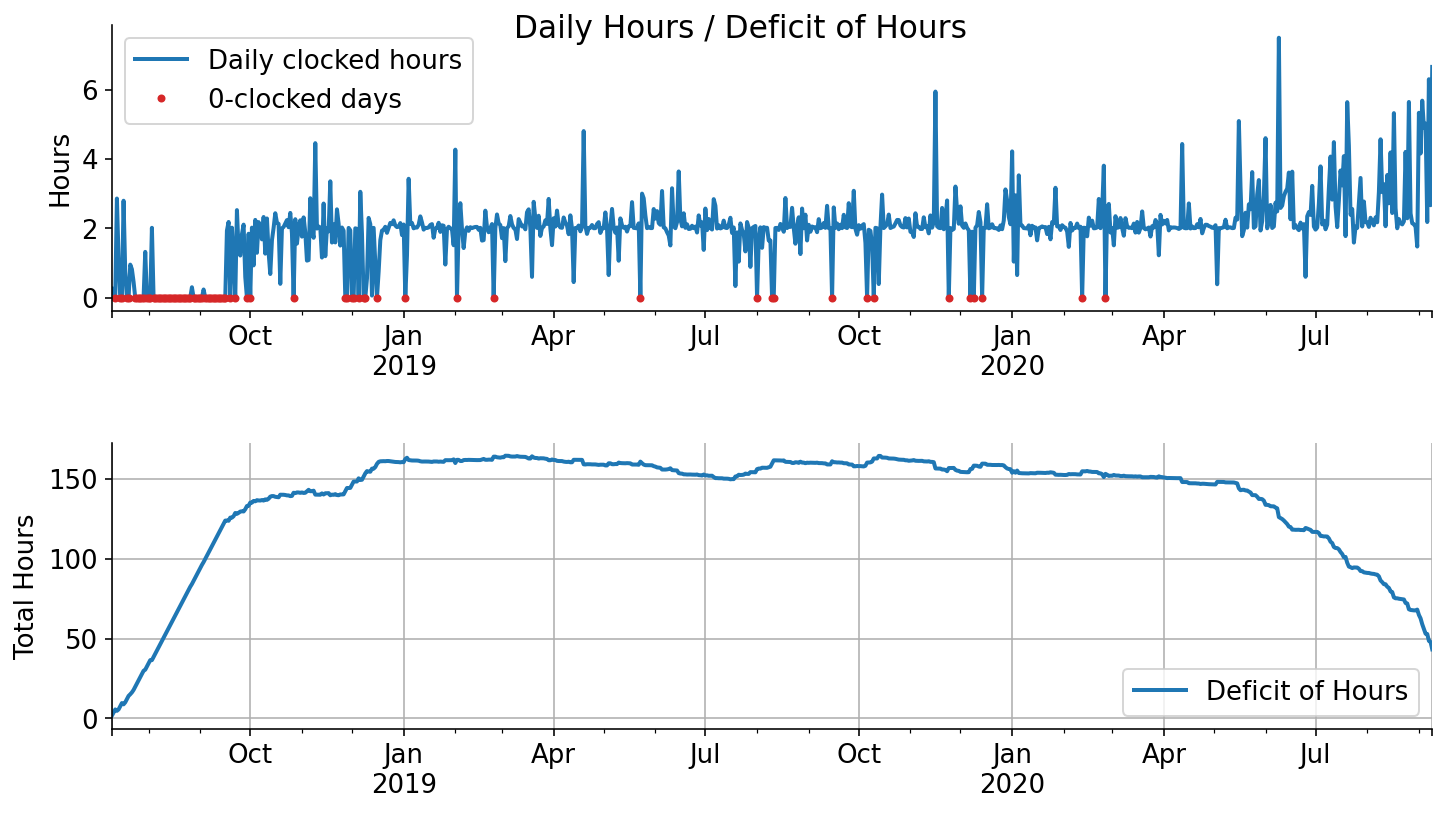

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax, ax2 = ax
total_hours_deficit.plot(ax=ax2, label="Deficit of Hours", linewidth=2)
hours_per_day.plot(ax=ax, label="Daily clocked hours", linewidth=2)
ax2.legend()
ax.legend()
ax2.grid()
plt.tight_layout()
(hours_per_day[map_no_study].reset_index()
                            .plot(x="start", y="clocked_hours",
                                  linewidth=0, marker="o", ax=ax,
                                  c="tab:red", markersize=3,
                                  label="0-clocked days"))
ax.set_xlabel(None)
ax2.set_xlabel(None)
plt.suptitle("Daily Hours / Deficit of Hours")
ax.set_ylabel("Hours")
ax2.set_ylabel("Total Hours")
# plt.savefig("daily-hours-deficit.png", dpi=120)

In [28]:
map_no_study.sum()

85

In [29]:
(hours_per_day["2018-08-27":] == 0).mean()

0.06442953020134229

In [30]:
zero_clocked = hours_per_day[map_no_study]["2018-08-27":].resample("M").count().replace(0, np.nan).dropna()
zero_clocked.index = [v.strftime("%Y-%m") for v in zero_clocked.index]
zero_clocked.name = "zero-clocked-days-by-month"

In [31]:
zero_clocked.sum()

48.0

In [32]:
zero_clocked

2018-08     4.0
2018-09    18.0
2018-10     2.0
2018-11     2.0
2018-12     6.0
2019-01     1.0
2019-02     2.0
2019-05     1.0
2019-08     3.0
2019-09     1.0
2019-10     2.0
2019-11     1.0
2019-12     3.0
2020-02     2.0
Name: zero-clocked-days-by-month, dtype: float64

In [33]:
total_hours_deficit.iloc[-1]

43.273157777778124

In [34]:
map_no_study.mean()

0.10718789407313997

Text(5.915000000000006, 0.5, 'Frequency')

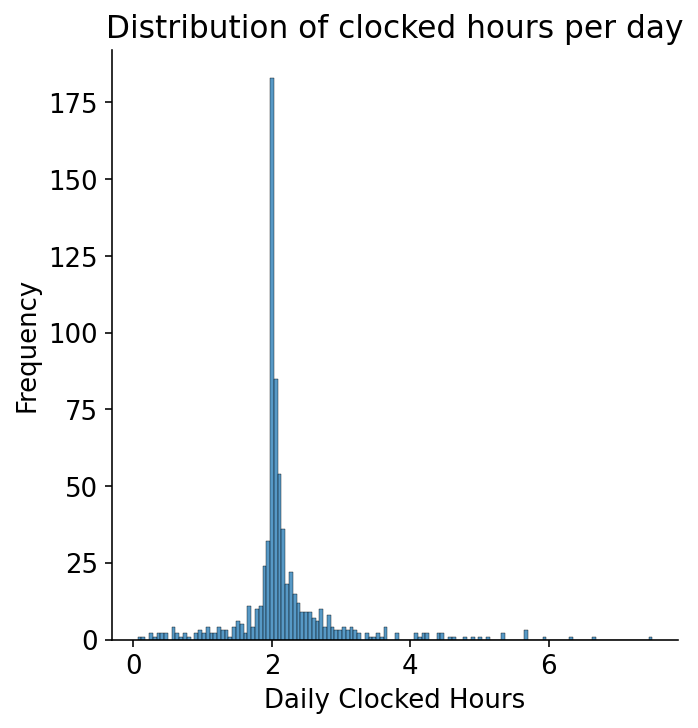

In [52]:
sns.displot(hours_per_day[~map_no_study], kde=False)
plt.title("Distribution of clocked hours per day")
plt.xlabel("Daily Clocked Hours")
plt.ylabel("Frequency")
# plt.savefig("hourly-distribution.png", dpi=120);

In [53]:
hours_per_day.mean()

1.9454310746812387

In [39]:
hours_per_day.std()

0.9802408173262988

In [40]:
1.94 / 2

0.97

In [41]:
hours_per_day[~map_no_study].mean()

2.178992715003139

In [42]:
hours_per_day[~map_no_study].mean() + np.array([-1, 1]) * hours_per_day[~map_no_study].std()

array([1.4261679 , 2.93181753])

In [43]:
# Total number of days
prml["clocked_hours"].sum() / 24

64.28028509259259

In [93]:
start_values = prml.reset_index()[["start", "clocked_hours"]]
start_values["weekday"] = start_values["start"].apply(lambda v: v.weekday())
start_values["time"] = start_values["start"].apply(lambda v: v.hour + v.minute / 60)

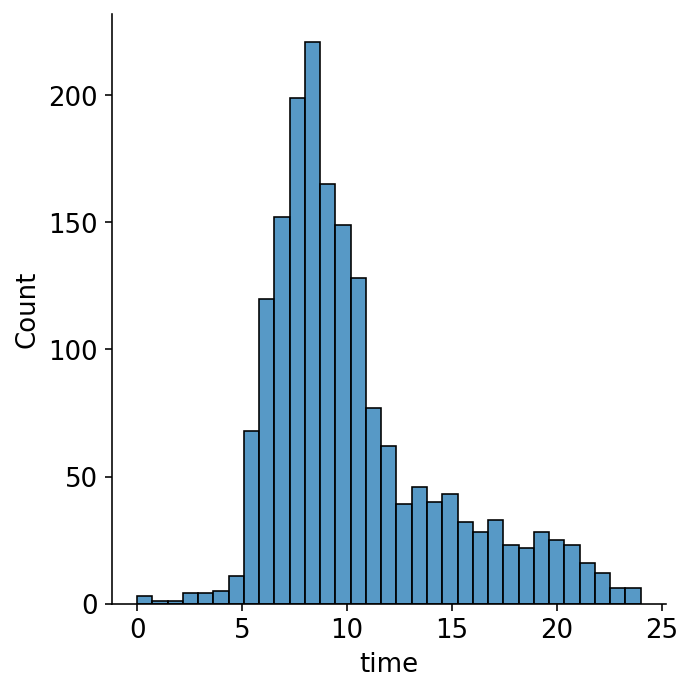

In [105]:
sns.displot(start_values, x="time")
plt.savefig("time-study-distribution.png", dpi=120)

In [108]:
mu_start = start_values["time"].mean()
mu_start

10.389118303571431

In [112]:
start_values["time"].median()

9.225

In [109]:
std_start = start_values["time"].std()
std_start

4.142980322439799

In [110]:
mu_start + np.array([-1,1]) * std_start 

array([ 6.24613798, 14.53209863])

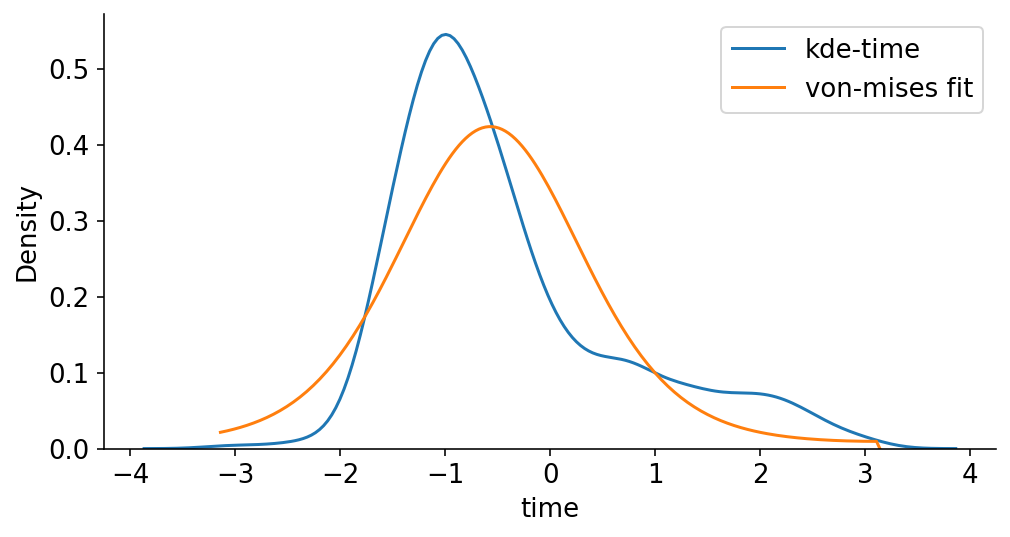

In [92]:
# Maybe try with mixture of von-mises?
from scipy.stats import vonmises_line
xrange = np.linspace(-np.pi, np.pi, 200)
rad_time = start_values["time"] * np.pi / 12 - np.pi
G = vonmises_line(*vonmises_line.fit(rad_time))
sns.kdeplot(rad_time, label="kde-time")
plt.plot(xrange, G.pdf(xrange), label="von-mises fit")
plt.legend()

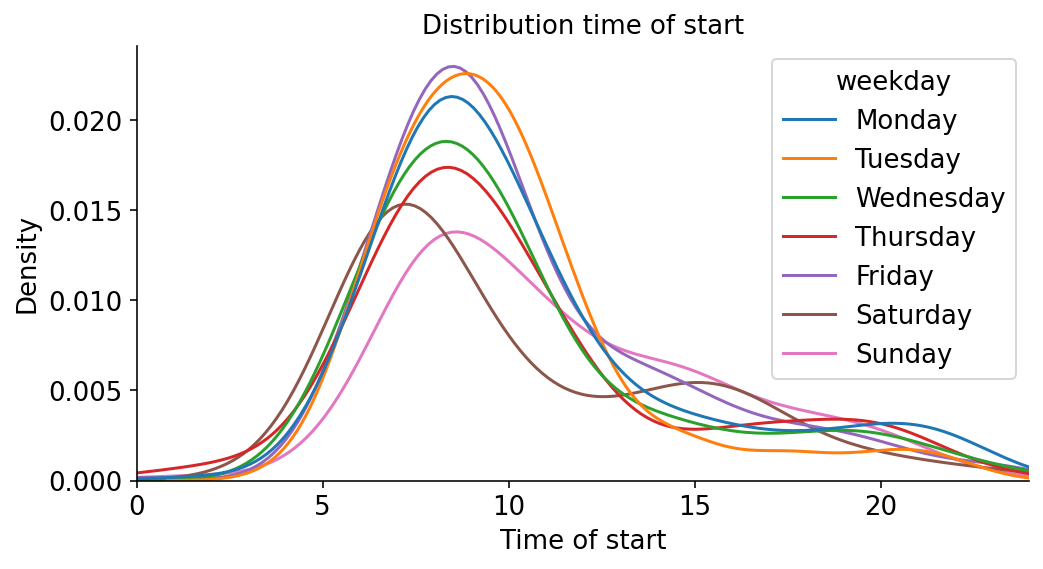

In [113]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday",
            "Friday", "Saturday", "Sunday"]

weekday = start_values["weekday"].apply(lambda v: weekdays[v])
sns.kdeplot(start_values["time"], hue=weekday, hue_order=weekdays)
plt.title("Distribution time of start", fontsize=13, )
plt.xlabel("Time of start")
plt.xlim(0, 24)
plt.savefig("time-study-distribution-weekday.png", dpi=120)

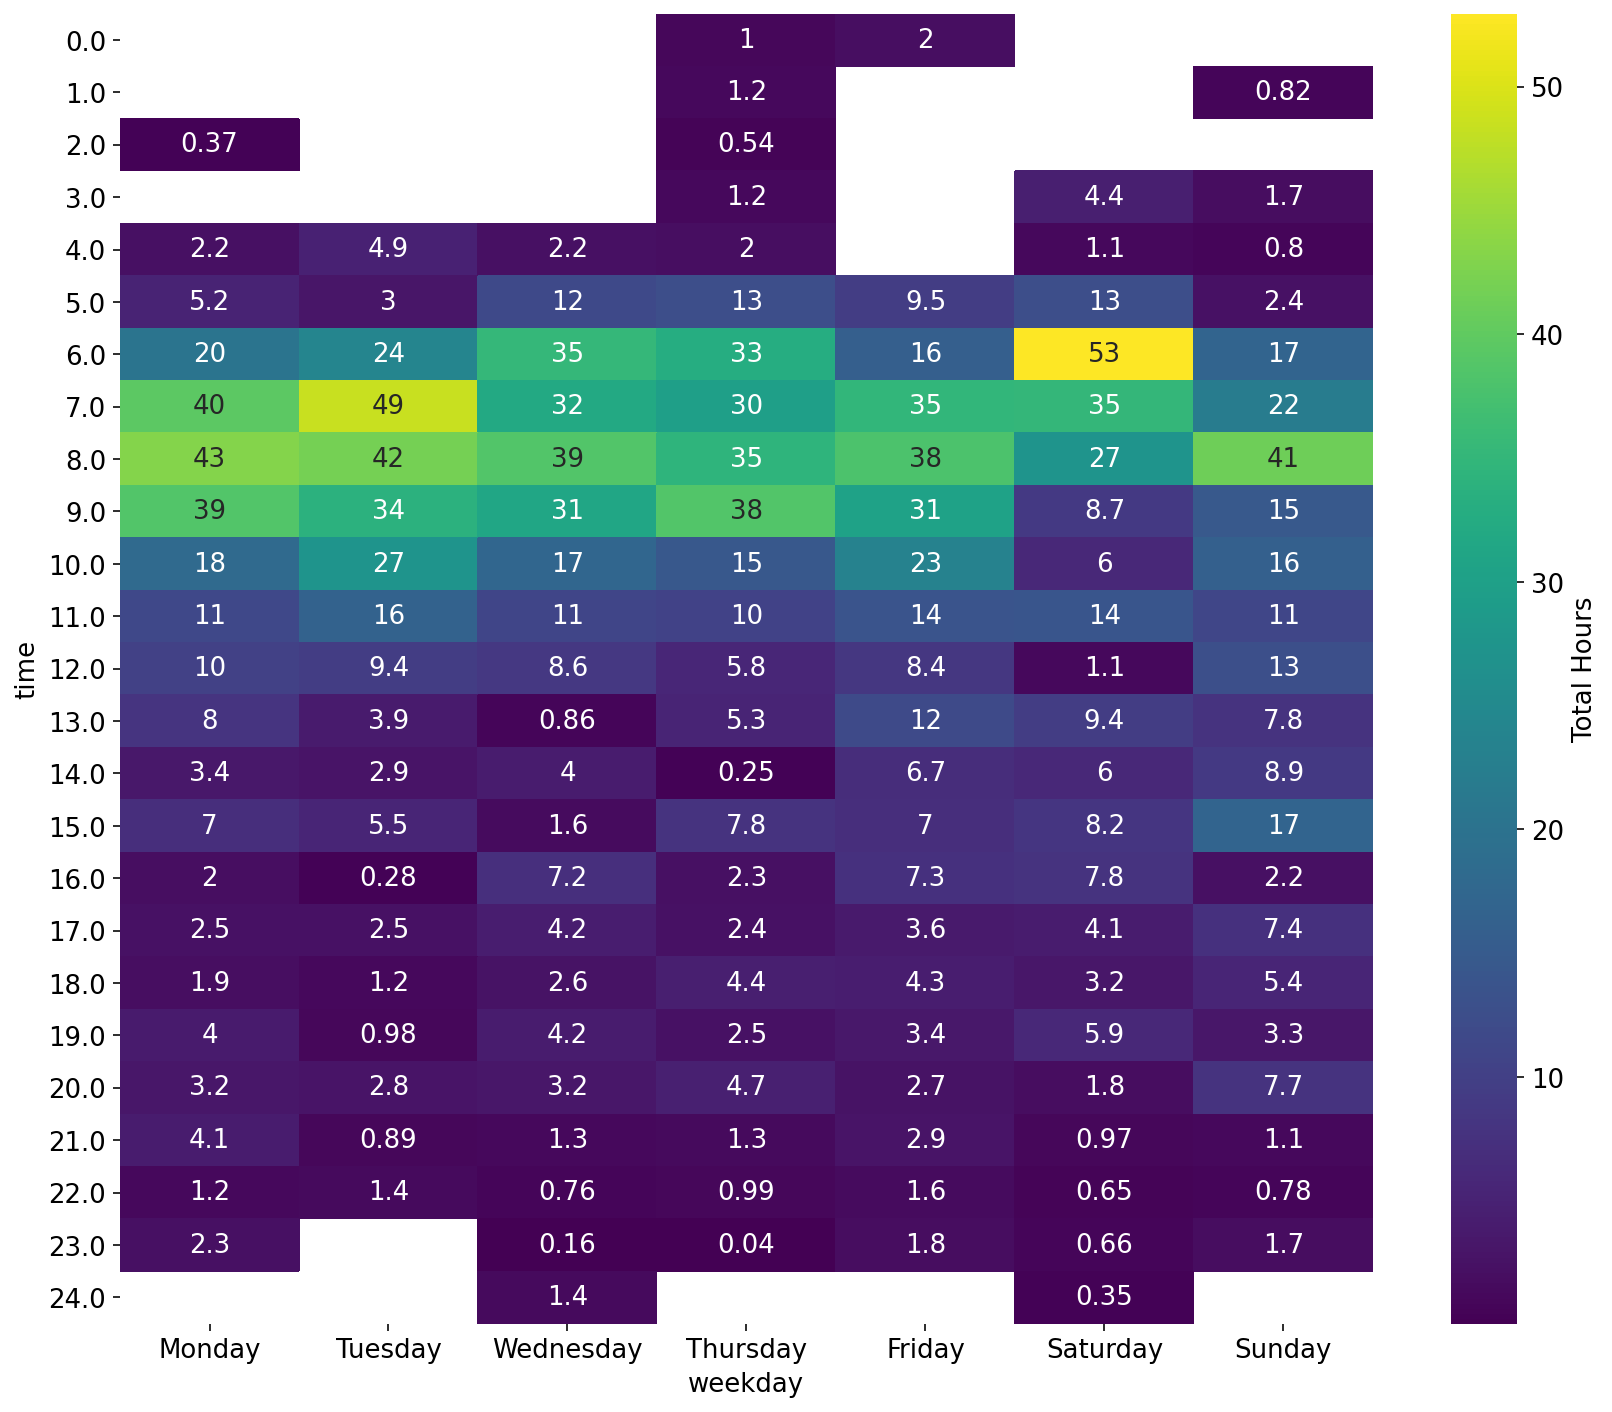

In [101]:
# Total total number of clocked hours groupped by starting time and weekday
time_distribution = (start_values.assign(time=start_values.time.round(0))
                                 .pivot_table(columns="weekday", index="time",
                                              values="clocked_hours", aggfunc="sum"))

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(time_distribution, annot=True, cmap="viridis",
            xticklabels=weekdays, cbar_kws={"label": "Total Hours"})
plt.tight_layout()
plt.savefig("heatmap-time-init.png", dpi=120)


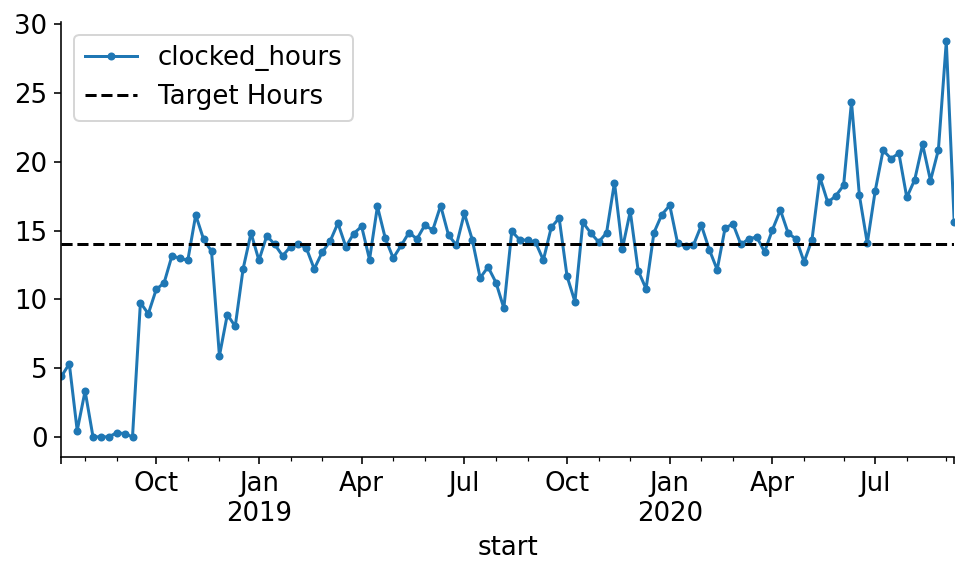

In [169]:
hours_per_week = prml.resample("W")["clocked_hours"].sum()
hours_per_week.plot(marker="o", markersize=3)
plt.axhline(y=14, c="black", linestyle="--", label="Target Hours")

plt.legend();

In [170]:
(hours_per_week >= 14).mean()

0.5526315789473685

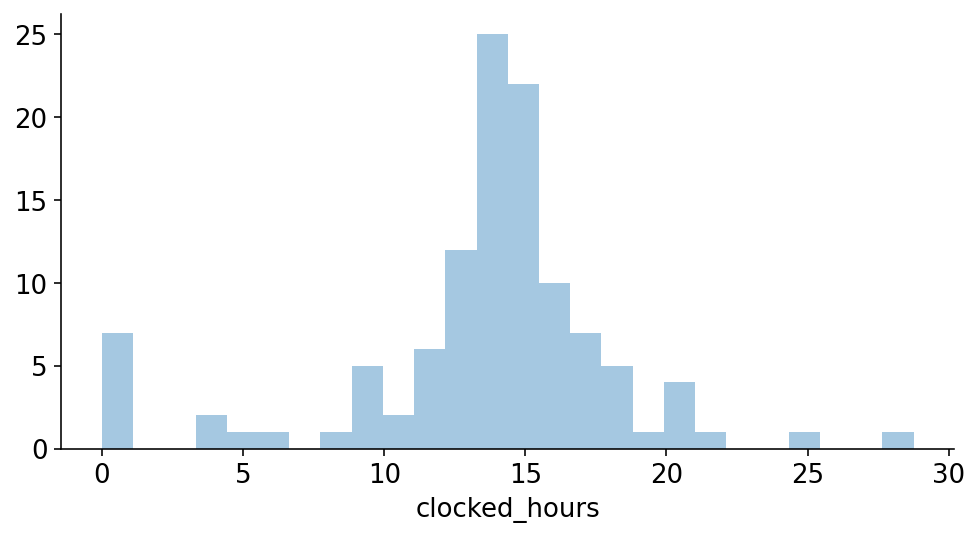

In [171]:
sns.distplot(hours_per_week, kde=False)

In [172]:
hours_per_day = prml.resample("D")["clocked_hours"].sum()

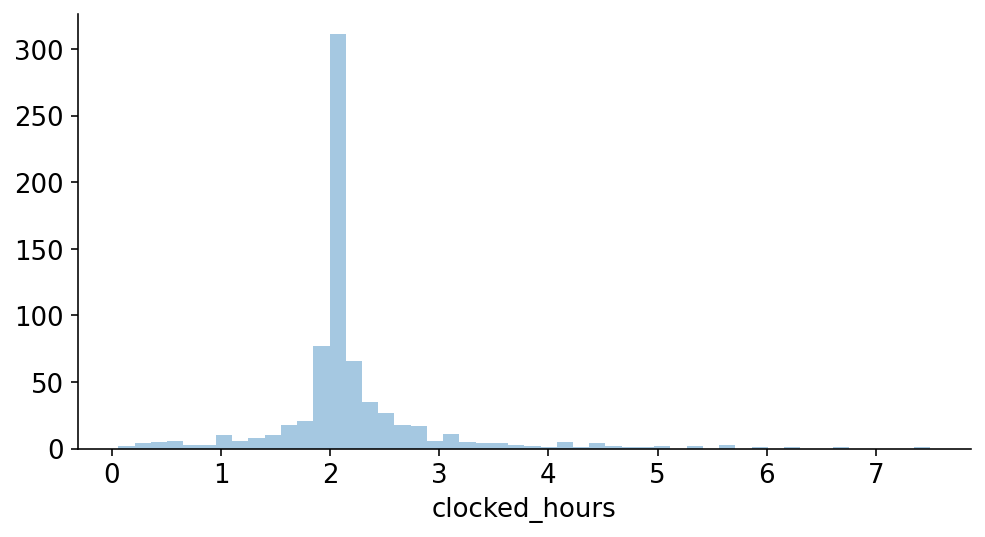

In [173]:
sns.distplot(hours_per_day[hours_per_day != 0], kde=False)

In [174]:
start_values.set_index("start").resample("H").sum()

,clocked_hours,weekday,time
start,,,
2018-07-10 17:00:00-05:00,0.256944,1,17.333333
2018-07-10 18:00:00-05:00,0.000000,0,0.000000
2018-07-10 19:00:00-05:00,0.000000,0,0.000000
2018-07-10 20:00:00-05:00,0.000000,0,0.000000
2018-07-10 21:00:00-05:00,0.000000,0,0.000000
...,...,...,...
2020-09-09 15:00:00-05:00,0.000000,0,0.000000
2020-09-09 16:00:00-05:00,1.498333,2,16.783333
2020-09-09 17:00:00-05:00,0.000000,0,0.000000


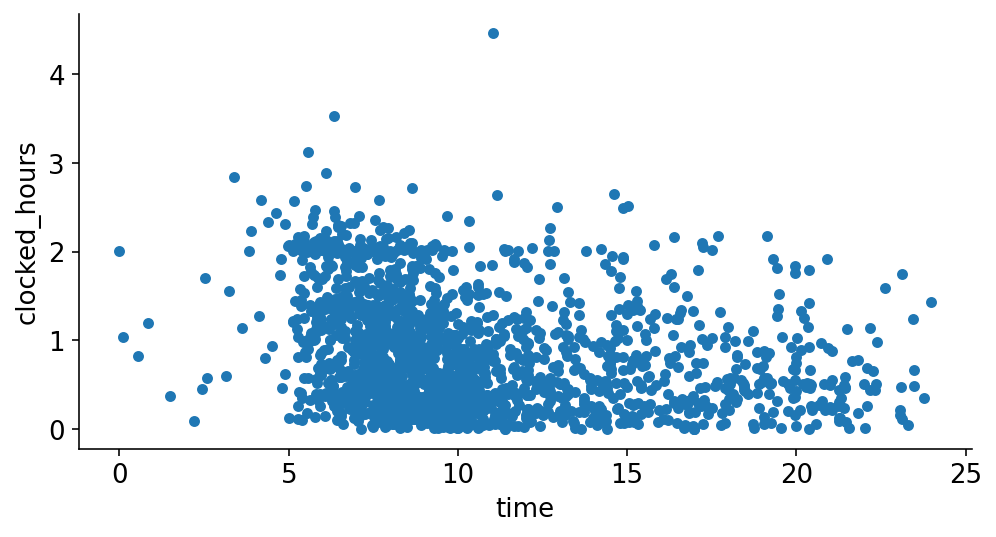

In [175]:
start_values.plot.scatter(x="time", y="clocked_hours")

## Chapter Analysis

In [121]:
prml["description"].unique()

array(['Bishop Ch3', 'Bishop Ch1', 'Bishop Ch.1', 'Bishop Ch.1 notes',
       'Bishop Ch.2', 'Bishop Ch.3', 'Bishop Ch.4', 'Bishop Ch.5',
       'Bishop Ch.6', 'Bishop Ch.7', 'Bishop Ch.8', 'Bishop Ch.9',
       'Bishop Ch.10', 'Bishop Ch.11', 'Bishop Ch.12', 'Bishop Ch.13',
       'Bishop Ch.14'], dtype=object)

In [122]:
ms_chapter = (prml.assign(chapter=prml.description.str.extract("([0-9]+)").astype(int))
                  .groupby("chapter")["dur"]
                  .sum())
hour_chapter = ms_chapter * 0.001 / 60 ** 2
hour_chapter.name = "study-hours"

hour_chapter.mean() + np.array([-1, 1]) * hour_chapter.std()

array([ 48.37454781, 172.01500108])

In [123]:
hour_chapter.index = chapter_names
hour_chapter

Chapter 1: Introduction                        128.755833
Chapter 2: Probability distributions           208.143611
Chapter 3: Linear Models for Regression        105.791389
Chapter 4: Linear Models for Classification    102.149167
Chapter 5: Neural Networks                     200.052120
Chapter 6: Kernel Methods                       61.676944
Chapter 7: Sparse Kernel Machines               79.763056
Chapter 8: Graphical Models                     96.968333
Chapter 9: Mixture Models and EM                79.607500
Chapter 10: Approximate Inference              226.593056
Chapter 11: Sampling Methods                    27.502500
Chapter 12: Continuous Latent Variables         91.390833
Chapter 13: Sequential Data                    104.260833
Chapter 14: Combining Models                    30.071667
Name: study-hours, dtype: float64

/Users/gerardoduran/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  This is separate from the ipykernel package so we can avoid doing imports until


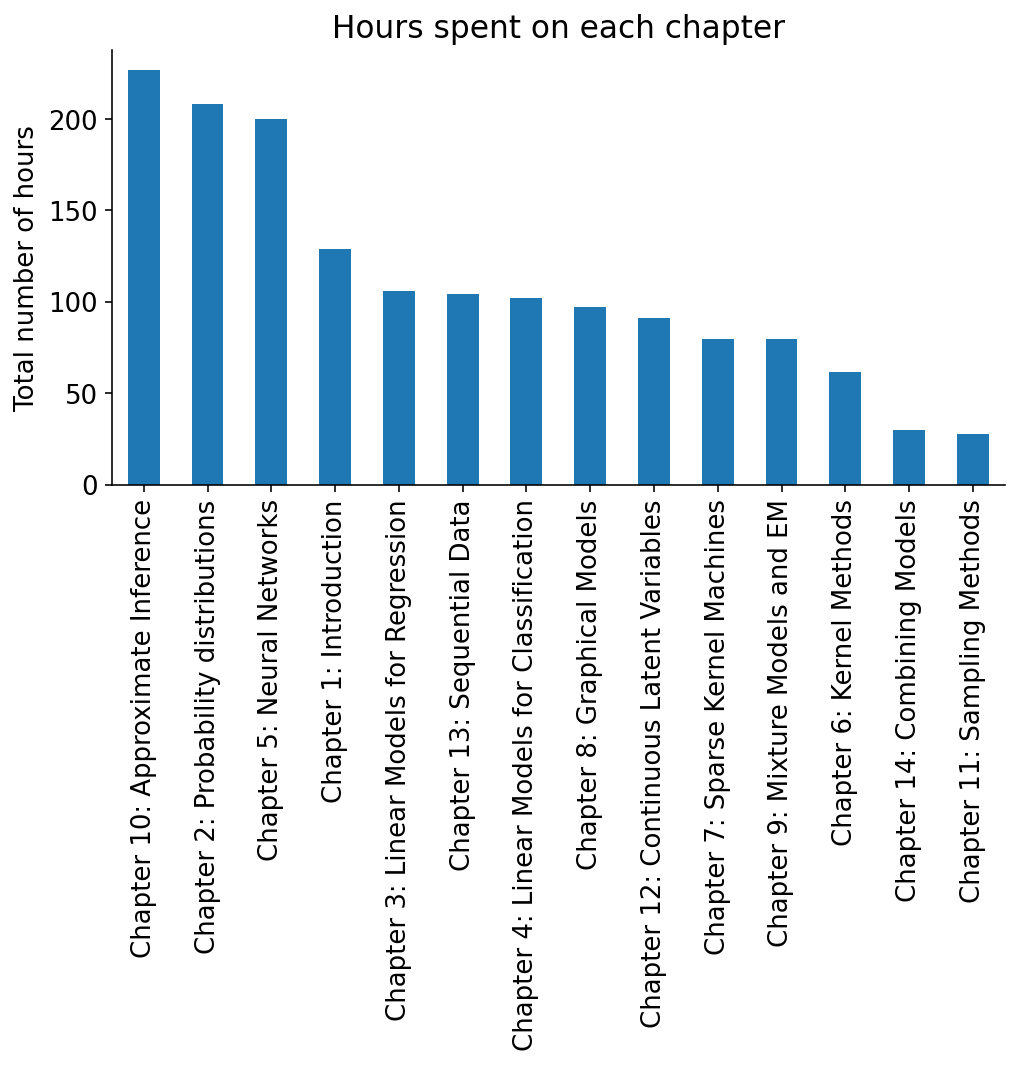

In [136]:
hour_chapter.sort_values(ascending=False).plot.bar()
plt.title("Hours spent on each chapter");
plt.tight_layout()
plt.ylabel("Total number of hours")
plt.savefig("hours-per-chapter.png", dpi=120)

In [124]:
# Chapter with longest time of study
hour_chapter.idxmax()

'Chapter 10: Approximate Inference'

In [125]:
# Chapter with shortest time of study
hour_chapter.idxmin()

'Chapter 11: Sampling Methods'

In [127]:
chapter_pages = [1, 67, 137, 179, 225, 291, 325, 359,
                 423, 461, 523, 559, 605, 653, 677]
chapter_pages = np.array([end - start for start, end in zip(chapter_pages[:-1], chapter_pages[1:])])

Text(0, 0.5, 'Total number of hours')

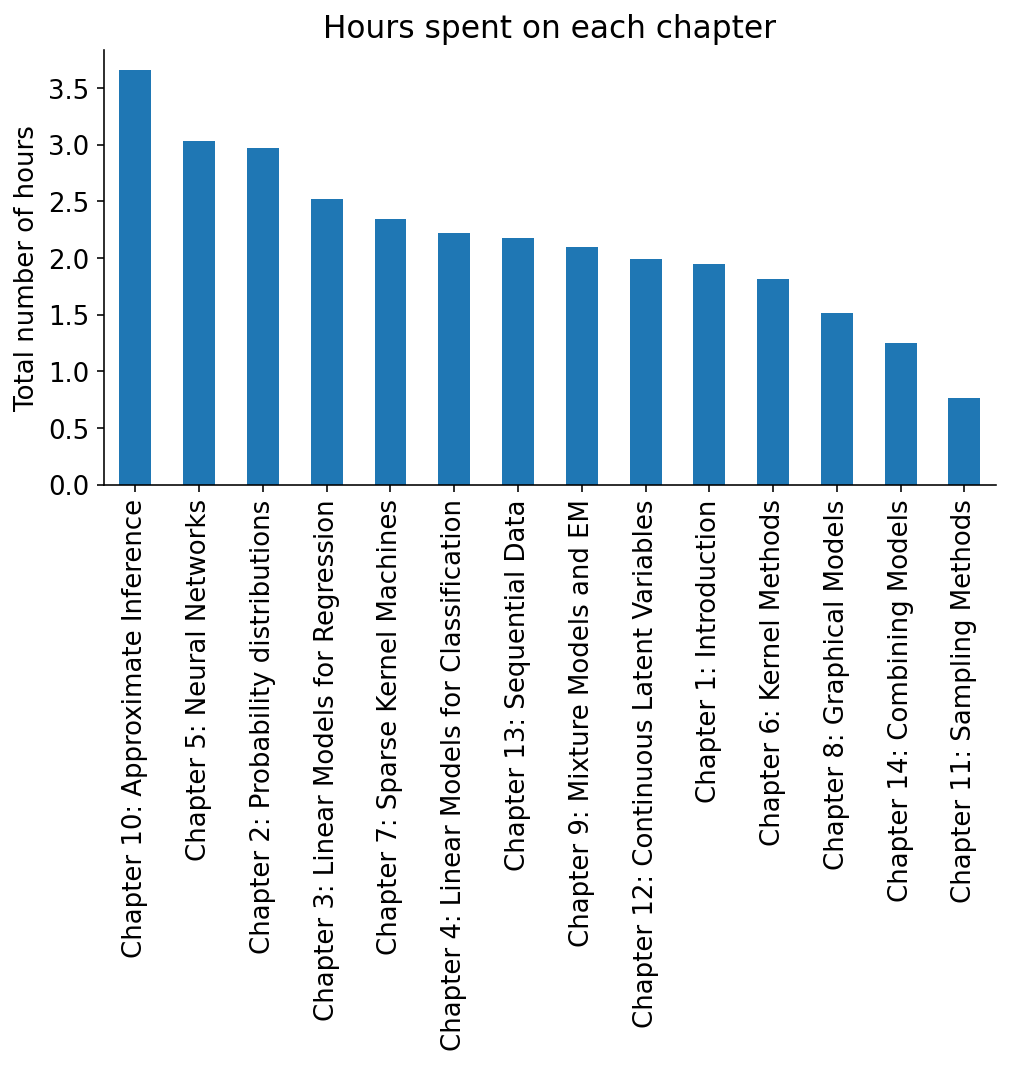

In [138]:
(hour_chapter / chapter_pages).sort_values(ascending=False).plot.bar()
plt.title("Hours spent on each chapter");
plt.ylabel("Total number of hours")
#plt.savefig("hours-per-chapter.png", dpi=120)

In [126]:
void_elements = ["Bishop Ch3", "Bishop Ch1", "Bishop Ch.1 notes"]
chapter_started = (prml[["description", "clocked_hours"]]
                       .drop_duplicates(subset="description")
                       .query("description not in @void_elements"))
chapter_started

,description,clocked_hours
start,,
2018-08-27 11:15:15-05:00,Bishop Ch.1,0.300000
2018-11-23 05:37:18-06:00,Bishop Ch.2,0.323611
2019-03-18 07:47:05-06:00,Bishop Ch.3,0.548333
2019-05-07 08:48:03-05:00,Bishop Ch.4,1.023056
2019-06-12 10:15:13-05:00,Bishop Ch.5,0.371111
2019-09-19 06:19:06-05:00,Bishop Ch.6,0.481389
2019-11-06 05:34:28-06:00,Bishop Ch.7,2.045278
2019-12-15 07:40:58-06:00,Bishop Ch.8,0.589167
2020-01-29 06:32:16-06:00,Bishop Ch.9,0.139722


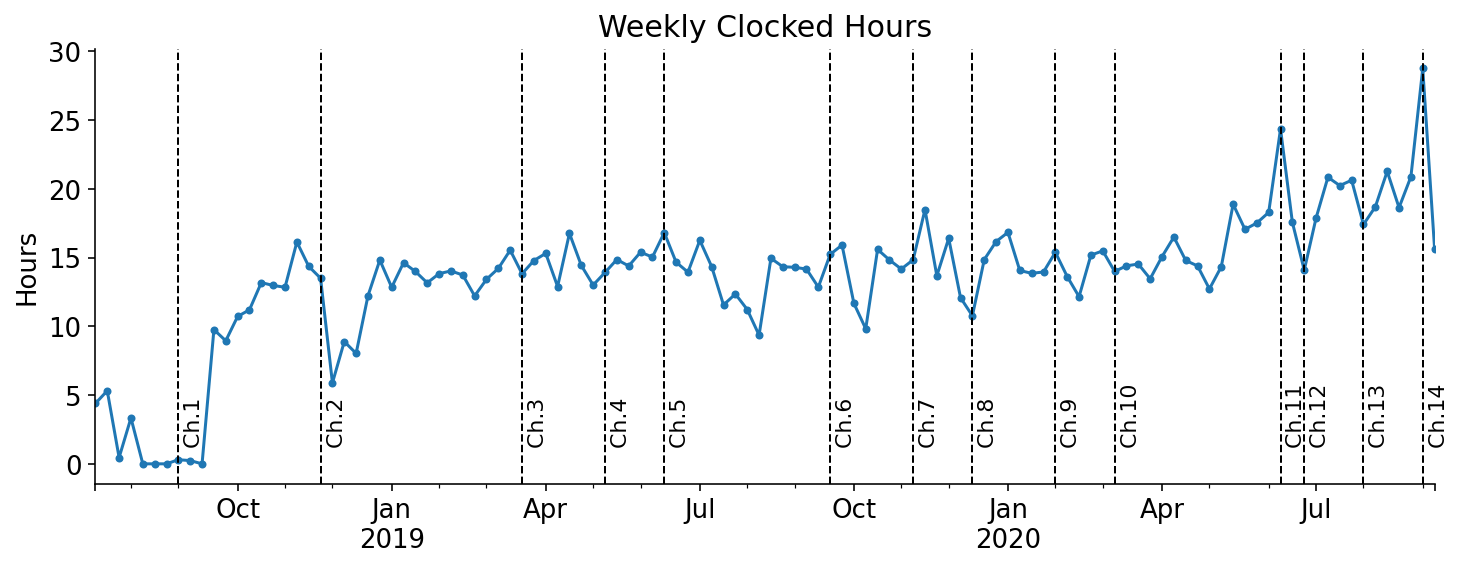

In [182]:
fig, ax = plt.subplots(figsize=(12, 4))

hours_per_week.plot(marker="o", markersize=3)
for ix, chapter in chapter_started.iterrows():
    chapter = chapter["description"]
    chapter = chapter.lstrip("Bishop")
    line = plt.axvline(x=ix, linestyle="--", c="black", linewidth=1)
    x, y = line.get_xydata()[-1]
    plt.text(x + 0.5, y, chapter, rotation=90, fontsize=11)
# plt.axhline(y=14, c="tab:gray", linestyle="-", label="Target Hours", alpha=0.6)
plt.title("Weekly Clocked Hours", fontsize=15);
plt.xlabel(None);
plt.ylabel("Hours", fontsize=13)
plt.savefig("weekly-clocked-hours.png", bbox_inches="tight", dpi=100)

## References
* [Detailed Report](https://github.com/toggl/toggl_api_docs/blob/master/reports/detailed.md)
* [Toggl Reports](https://github.com/toggl/toggl_api_docs/blob/master/reports.md)